# **IMPORTANDO E ANALISANDO OS DADOS**

In [26]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split

# desabilita os warnings
import warnings
warnings.filterwarnings('ignore')

In [11]:
df = pd.read_csv("StudentsPerformance.csv")
df

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75
...,...,...,...,...,...,...,...,...
995,female,group E,master's degree,standard,completed,88,99,95
996,male,group C,high school,free/reduced,none,62,55,55
997,female,group C,high school,free/reduced,completed,59,71,65
998,female,group D,some college,standard,completed,68,78,77


**Verificando se há dados nulos:**

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


In [13]:
df.isna().sum()

gender                         0
race/ethnicity                 0
parental level of education    0
lunch                          0
test preparation course        0
math score                     0
reading score                  0
writing score                  0
dtype: int64

In [14]:
df.nunique()

gender                          2
race/ethnicity                  5
parental level of education     6
lunch                           2
test preparation course         2
math score                     81
reading score                  72
writing score                  77
dtype: int64

**Verificando se há dados duplicados:**

In [15]:
df.duplicated().sum()

0

**Vamos criar uma coluna de média das notas que servirá como target:**

In [16]:
curso_notas = df[["test preparation course", "math score", "reading score", "writing score"]]
df_notas = df[["math score", "reading score", "writing score"]]

In [17]:
lista_col = []
lista_media = []
for col in df_notas:
    lista_col.append(col)
for num in range(len(df_notas)):
  media = (df_notas[lista_col[0]].iloc[num] + df_notas[lista_col[1]].iloc[num] + df_notas[lista_col[2]].iloc[num])/3
  lista_media.append(media)
curso_notas["media"] = lista_media
df["media"] = lista_media
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,media
0,female,group B,bachelor's degree,standard,none,72,72,74,72.666667
1,female,group C,some college,standard,completed,69,90,88,82.333333
2,female,group B,master's degree,standard,none,90,95,93,92.666667
3,male,group A,associate's degree,free/reduced,none,47,57,44,49.333333
4,male,group C,some college,standard,none,76,78,75,76.333333


# **XGBOOST**

## **Black Box**

In [27]:
#Separando o que é features e target:
X = df.drop(columns="media")
y = df["media"]

# Dividindo em dados de teste e dados de treino, peguei 20% para dados de teste:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

# Iniciando a construção da Pipeline:
# ==========================================================
#Primeiro vamos tratar as features numéricas. Tratando os valores nulos (NaN) e escalonando já que a variância entre as features é grande.
pipe_features_num = Pipeline([("input_num", SimpleImputer(strategy="mean")),
                              ("std", StandardScaler())])

features_num = X_train.select_dtypes(include=np.number).columns.tolist()
# ==========================================================
# ==========================================================
# Tratando as features categóricas. Os valores nulos (NaN) serão preenchidos pelos dados mais constantes e posteriormente codificaremos todas elas com Ordinal Enconder. 

pipe_features_oe = Pipeline([("input_cat_oe", SimpleImputer(strategy="constant", fill_value="unknown")),
                            ("ordinal", OrdinalEncoder())])

features_oe = ["race/ethnicity", "parental level of education"]

# Tratando as features categóricas. Os valores nulos (NaN) serão preenchidos pelos dados mais constantes e posteriormente codificaremos todas elas com o One Hot Encoder. 

pipe_features_ohe = Pipeline([("input_cat_oe", SimpleImputer(strategy="constant", fill_value="unknown")),
                            ("onehot", OneHotEncoder(handle_unknown='ignore'))])

features_ohe = ["gender", "lunch", "test preparation course"]
# ==========================================================
# Pré-processador => Pegando as pipelines anteriores e unindo-as.
pre_processador = ColumnTransformer([("transf_num", pipe_features_num, features_num),
                                     ("transf_cat", pipe_features_oe, features_oe)])

# ==========================================================
# Pipeline final, usando o pré-processador e o estimador que queremos utilizar, neste caso o XGBoost para regressão.
pipe_xgbr = Pipeline([("pre_processador", pre_processador),
                     ("xgbr", XGBRegressor(eval_metric='logloss', random_state=42))])

# ==========================================================
#Vamos dividir em splits para ter mais variedade no processamento dos dados.
splitter = KFold(n_splits=5, random_state=42, shuffle=True)

#Montando a grade de parâmetros do estimador (XGBoost)
params_grid_xgbr = {"xgbr__n_estimators": [5000],
                   "xgbr__max_depth": [2, 3],
                   "xgbr__learning_rate": [0.001, 0.01],
                   "xgbr__colsample_bytree": [0.5],
                   "xgbr__subsample": [0.5]}


#Motando a grade geral de parâmetros.
grid_xgbr_edu = GridSearchCV(estimator=pipe_xgbr,
                       param_grid=params_grid_xgbr,
                       scoring="r2",
                       cv=splitter,
                       verbose=10,
                       n_jobs=-1)

grid_xgbr_edu.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[17:47:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('pre_processador',
                                        ColumnTransformer(transformers=[('transf_num',
                                                                         Pipeline(steps=[('input_num',
                                                                                          SimpleImputer()),
                                                                                         ('std',
                                                                                          StandardScaler())]),
                                                                         ['math '
                                                                          'score',
                                                                          'reading '
                                                                          'score',
                                    

In [29]:
grid_xgbr_edu.best_params_

{'xgbr__colsample_bytree': 0.5,
 'xgbr__learning_rate': 0.01,
 'xgbr__max_depth': 3,
 'xgbr__n_estimators': 5000,
 'xgbr__subsample': 0.5}

In [20]:
xgbr_results = pd.DataFrame(grid_xgbr_edu.cv_results_)
xgbr_results.sort_values(by=["rank_test_score"])

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_xgbr__colsample_bytree,param_xgbr__learning_rate,param_xgbr__max_depth,param_xgbr__n_estimators,param_xgbr__subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,0.347742,0.010735,0.012179,0.001472,0.5,0.01,2,1000,0.5,"{'xgbr__colsample_bytree': 0.5, 'xgbr__learnin...",0.998586,0.994605,0.998753,0.998991,0.998737,0.997934,0.001670,1
0,0.535079,0.170088,0.023484,0.013511,0.5,0.001,2,1000,0.5,"{'xgbr__colsample_bytree': 0.5, 'xgbr__learnin...",-2.201490,-2.244300,-2.346016,-2.378783,-2.333809,-2.300879,0.066738,2


In [33]:
# Predições de treino
y_pred_train = grid_xgbr_edu.predict(X_train)

print("\nMétricas de treino:\n")
print(f"R^2: {r2_score(y_train, y_pred_train):.2f}")
print(f"MAE: {mean_absolute_error(y_train, y_pred_train):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_train, y_pred_train)):.2f}")

# Predições de teste
y_pred_test = grid_xgbr_edu.predict(X_test)

print("\nMétricas de teste:\n")
print(f"R^2: {r2_score(y_test, y_pred_test):.2f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_test):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_test)):.2f}") 


Métricas de treino:

R^2: 1.00
MAE: 0.08
RMSE: 0.09

Métricas de teste:

R^2: 1.00
MAE: 0.14
RMSE: 0.20




---



**Nos dois gráficos abaixos percebemos que os dados de treinos não gabaritaram(não gravaram a resposta) e, sim, geraram erros extremamentes pequenos. Isso se dá pela coesão dos dados. Podemos ver pela MAE, se houvesse gabaritado as respostas os dados de treino não gerariam erros.**

Peguei um exemplo:

In [30]:
df.iloc[[0]]

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,media
0,female,group B,bachelor's degree,standard,none,72,72,74,72.666667


In [32]:
grid_xgbr_edu.predict(df.iloc[[0]])


array([72.60629], dtype=float32)



---



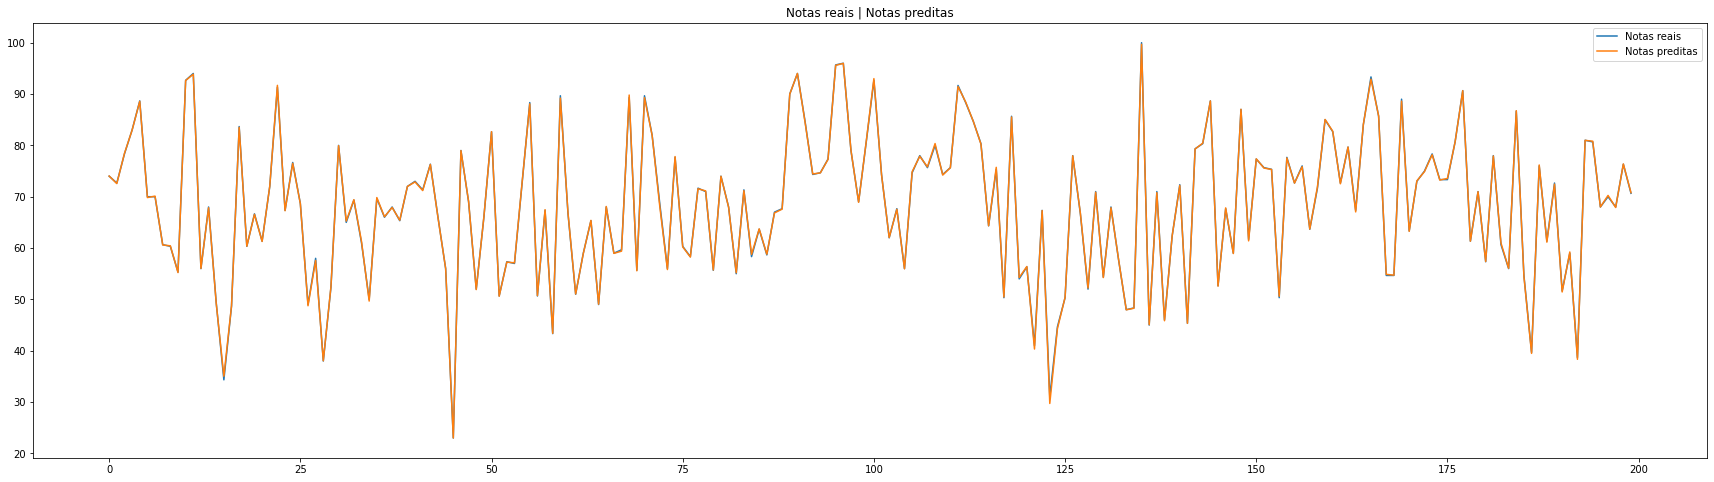

In [34]:
plt.figure(figsize=(30,8))
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="Notas reais")
plt.plot(x_ax, y_pred_test, label="Notas preditas")
plt.title("Notas reais | Notas preditas")
plt.legend()
plt.show();

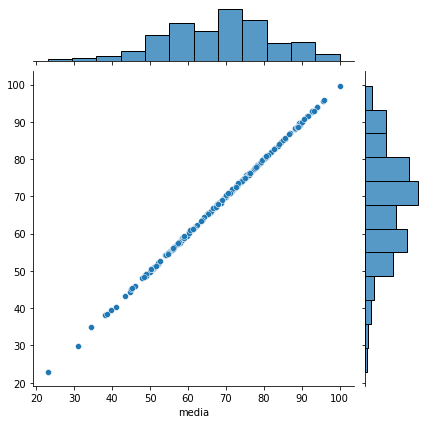

In [35]:
sns.jointplot(y_test, y_pred_test)
plt.xlabel("Valores reais")
plt.ylabel("Valores preditos");

In [36]:
import pickle

In [38]:
with open("grid_xgbr_edu.pkl", "wb") as f:
    pickle.dump(grid_xgbr_edu, f)

In [ ]:
with open("grid_xgbr_edu.pkl", "rb") as f:
    
    grid_xgbr_edu = pickle.load(f)

**Vamos criar uma tabela com a porcentagem de acertos para cada dado**

In [39]:
tabela = pd.DataFrame()

In [40]:
tabela["valores reais"] = y_test

In [41]:
tabela["valores preditos"] = y_pred_test

In [42]:
tabela

,valores reais,valores preditos
518,74.000000,74.022049
871,72.666667,72.554283
797,78.333333,78.446815
274,83.000000,82.962883
325,88.666667,88.579971
...,...,...
909,68.000000,68.002556
757,70.000000,70.254868
965,68.000000,67.900597
4,76.333333,76.378593


In [43]:
tabela.to_csv("07_educacao_xgbr.csv")

## **Intervalo de confiança do XGBoost - Vamos simular intervalos para amostras com 30 e 100 dados:**

In [44]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, KFold
from scipy.stats import norm
from scipy import stats
from scipy.stats import t

In [45]:
df = pd.read_csv("StudentsPerformance.csv")

In [46]:
curso_notas = df[["test preparation course", "math score", "reading score", "writing score"]]
df_notas = df[["math score", "reading score", "writing score"]]

In [47]:
lista_col = []
lista_media = []
for col in df_notas:
    lista_col.append(col)
for num in range(len(df_notas)):
  media = (df_notas[lista_col[0]].iloc[num] + df_notas[lista_col[1]].iloc[num] + df_notas[lista_col[2]].iloc[num])/3
  lista_media.append(media)
curso_notas["media"] = lista_media
df["media"] = lista_media
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,media
0,female,group B,bachelor's degree,standard,none,72,72,74,72.666667
1,female,group C,some college,standard,completed,69,90,88,82.333333
2,female,group B,master's degree,standard,none,90,95,93,92.666667
3,male,group A,associate's degree,free/reduced,none,47,57,44,49.333333
4,male,group C,some college,standard,none,76,78,75,76.333333


**Transformando as Features categóricas em numéricas - OrdinalEncoder() - Feature com mais de 2 dados diferentes.**

In [57]:
oe =  OrdinalEncoder()
oe.fit(df[["gender", "test preparation course", "lunch", "race/ethnicity", "parental level of education"]])

df[["gender", "test preparation course", "lunch", "race/ethnicity", "parental level of education"]] = oe.transform(df[["gender", "test preparation course", "lunch", "race/ethnicity", "parental level of education"]])

**Vamos escalonar todas as Features, pois a amplitude entre os dados está muito grande, isso pode causar um viés no resultado final:**

In [ ]:
df.columns

Index(['gender', 'race/ethnicity', 'parental level of education', 'lunch',
       'test preparation course', 'math score', 'reading score',
       'writing score', 'media'],
      dtype='object')

In [58]:
ssc = StandardScaler()

ssc.fit(df[['gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course', 'math score', 'reading score','writing score']])
h= ssc.transform(df[['gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course', 'math score', 'reading score', 'writing score']])
df[['gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course', 'math score', 'reading score', 'writing score']] = h

In [59]:
df

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,media
0,-0.964625,-1.015044,-0.812640,0.741881,0.746748,0.390024,0.193999,0.391492,72.666667
1,-0.964625,-0.150441,0.827953,0.741881,-1.339140,0.192076,1.427476,1.313269,82.333333
2,-0.964625,-1.015044,0.281088,0.741881,0.746748,1.577711,1.770109,1.642475,92.666667
3,1.036672,-1.879647,-1.359505,-1.347925,0.746748,-1.259543,-0.833899,-1.583744,49.333333
4,1.036672,-0.150441,0.827953,0.741881,0.746748,0.653954,0.605158,0.457333,76.333333
...,...,...,...,...,...,...,...,...,...
995,-0.964625,1.578765,0.281088,0.741881,-1.339140,1.445746,2.044215,1.774157,94.000000
996,1.036672,-0.150441,-0.265776,-1.347925,0.746748,-0.269803,-0.970952,-0.859491,57.333333
997,-0.964625,-0.150441,-0.265776,-1.347925,-1.339140,-0.467751,0.125472,-0.201079,65.000000
998,-0.964625,0.714162,0.827953,0.741881,-1.339140,0.126093,0.605158,0.589015,74.333333


In [60]:
#Separando o que é features e target:
X = df.drop(columns="media")
y = df["media"]

In [61]:
X = np.array(X)

**Com 30 e 90 amostras**

In [63]:
resultados_xgbr_cv_30 = []
resultados_xgbr_cv_100 = []
for i in range(10):
  kfold = KFold(n_splits = 10, shuffle = True, random_state = i)
  
  xgbr = XGBRegressor(objective ='reg:squarederror')
  scores = cross_val_score(xgbr, X, y, cv = kfold)
  resultados_xgbr_cv_100.append(scores)
  resultados_xgbr_cv_30.append(scores.mean())

In [64]:
scores

array([0.99774387, 0.99846307, 0.99790529, 0.99780912, 0.99820824,
       0.99843955, 0.99817466, 0.99177369, 0.99768445, 0.99584223])

In [65]:
resultados_xgbr_cv_30 = np.array(resultados_xgbr_cv_30)
resultados_xgbr_cv_100 = np.array(np.asarray(resultados_xgbr_cv_100).reshape(-1))

**Para 30 amostras usamos o t-student:**

In [67]:
intervalos_xgbr_t = t.interval(0.95, len(resultados_xgbr_cv_30) - 1, 
                                    resultados_xgbr_cv_30.mean(), 
                                    stats.sem(resultados_xgbr_cv_30, ddof = 0))
intervalos_xgbr_t

(0.9973661237090807, 0.9975139670780697)

**Variação do intervalo:**

In [68]:
abs(resultados_xgbr_cv_30.mean() - intervalos_xgbr_t[1])

7.392168449449343e-05

In [75]:
print(f"Temos 95% de confiança de que a média de acertos do XGBoost com 30 amostras está no intervalo entre {intervalos_xgbr_t[0]*100:.2f} % e {intervalos_xgbr_t[1]*100:.2f} % com variação de {abs(resultados_xgbr_cv_30.mean() - intervalos_xgbr_t[1])} para mais e para menos")

Temos 95% de confiança de que a média de acertos do XGBoost com 30 amostras está no intervalo entre 99.74 % e 99.75 % com variação de 7.392168449449343e-05 para mais e para menos


**Média do score:**

In [70]:
pd.DataFrame(resultados_xgbr_cv_30).mean()[0]

0.9974400453935752



---



**Para 100 amostras**

In [76]:
intervalos_xgbr_n = norm.interval(0.95, resultados_xgbr_cv_100.mean(), 
                                       stats.sem(resultados_xgbr_cv_100))
intervalos_xgbr_n

(0.9971194046112308, 0.9977606861759198)

**Para 100 amostras ele acabou aumentando a margem de erro em relação ao de 30 amostras, o que é esperado.**

**Variação do intervalo:**

In [77]:
abs(resultados_xgbr_cv_100.mean() - intervalos_xgbr_n[1])

0.00032064078234450566

In [78]:
print(f"Temos 95% de confiança de que a média de acertos do XGBoost com 90 amostras está no intervalo entre {intervalos_xgbr_n[0]*100:.2f}% e {intervalos_xgbr_n[1]*100:.2f}%")

Temos 95% de confiança de que a média de acertos do XGBoost com 90 amostras está no intervalo entre 99.71% e 99.78%


**Média do score:**

In [79]:
resultado_100 = resultados_xgbr_cv_100
resultado_100 = (resultado_100[0] + resultado_100[1] + resultado_100[2])/3
resultado_100

0.9982290689381452

#**INTERPRETANDO O MODELO GLOBALMENTE**

**SHAP**

In [80]:
df

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,media
0,-0.964625,-1.015044,-0.812640,0.741881,0.746748,0.390024,0.193999,0.391492,72.666667
1,-0.964625,-0.150441,0.827953,0.741881,-1.339140,0.192076,1.427476,1.313269,82.333333
2,-0.964625,-1.015044,0.281088,0.741881,0.746748,1.577711,1.770109,1.642475,92.666667
3,1.036672,-1.879647,-1.359505,-1.347925,0.746748,-1.259543,-0.833899,-1.583744,49.333333
4,1.036672,-0.150441,0.827953,0.741881,0.746748,0.653954,0.605158,0.457333,76.333333
...,...,...,...,...,...,...,...,...,...
995,-0.964625,1.578765,0.281088,0.741881,-1.339140,1.445746,2.044215,1.774157,94.000000
996,1.036672,-0.150441,-0.265776,-1.347925,0.746748,-0.269803,-0.970952,-0.859491,57.333333
997,-0.964625,-0.150441,-0.265776,-1.347925,-1.339140,-0.467751,0.125472,-0.201079,65.000000
998,-0.964625,0.714162,0.827953,0.741881,-1.339140,0.126093,0.605158,0.589015,74.333333


In [81]:
X = df.drop(columns=["media"])
y = df["media"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20)

In [ ]:
!pip install shap
import shap

In [83]:
xgbr = XGBRegressor(objective ='reg:squarederror').fit(X_train, y_train)

In [84]:
explainer = shap.TreeExplainer(xgbr)

In [85]:
shap_vals = explainer.shap_values(X_train)

**Temos abaixo as Features que mais impactaram na escolha dos valores preditivos para todos os dados:**

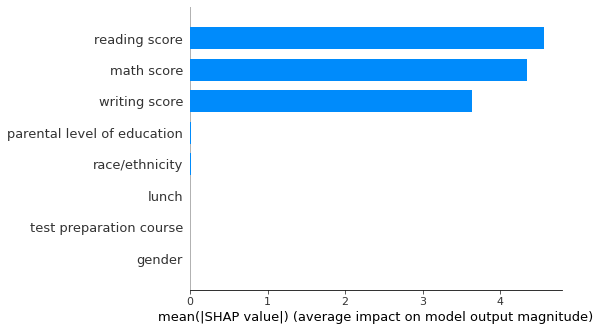

In [86]:
shap.summary_plot(shap_vals, X_train, plot_type="bar")